# Bee Orientation Project Experiment Notebook

This notebook provides a comprehensive script to run the entire experiment for the Bee Orientation project.
It covers dataset preparation, model definition, training, evaluation, visualization of predictions, and model analysis.

## 1. Setup and Imports

This section imports all necessary libraries and modules from the `src` directory of the `CV-BeeOrientation` repository.

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import project-specific modules
from src.dataset import BeeSegmentationDataset
from src.models.base import UNet3
from src.models.resunet import ResUNet18
from src.utils.split_dataset import split_dataset_two_stage
from src.utils.training import train_model
from src.utils.evaluation import evaluate_on_test, collect_evaluation_data, load_checkpoint
from src.utils import plots

## 2. Dataset Setup

This section checks if the dataset is already available.
If not, it downloads the original dataset archives, extracts them, and runs the preparation script to produce cropped images and masks ready for training.

In [10]:
!python scripts/prepare_dataset.py

Extracting frame_imgs_30fps.tgz...
Extracted to: data/raw
Extracting frame_annotations_30fps.tgz...
Extracted to: data/raw
Processing frames: 100% 361/361 [03:40<00:00,  1.64it/s]

Processed 130266 crops.
CSV saved to: data/processed/labels.csv


## 3. Configure and Load Dataset

Here, we configure parameters for the dataset and data loaders, including batch size and shuffling.
The `split_dataset_two_stage` utility splits the dataset into training, validation, and test sets.

In [2]:
# Dataset Configuration
DATA_IMAGES_PATH = "data/processed/images"
DATA_MASKS_PATH = "data/processed/masks"
CSV_PATH = "data/processed/labels.csv"
BATCH_SIZE = 64
SHUFFLE_TRAIN_DATA = True
RANDOM_SEED = 32817 # Generated during training
# Set device for training and inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Loading dataset from images: {DATA_IMAGES_PATH} and masks: {DATA_MASKS_PATH}")
dataset = BeeSegmentationDataset(DATA_IMAGES_PATH, DATA_MASKS_PATH)

train_dataset, val_dataset, test_dataset, seed = split_dataset_two_stage(dataset, seed=RANDOM_SEED)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN_DATA)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Using device: cpu
Loading dataset from images: data/processed/images and masks: data/processed/masks
Using provided seed: 32817
Dataset split:
  Train: 83369
  Val:   20843
  Test:  26054


## 4. Global Experiment Parameters

In [3]:
GLOBAL_LEARNING_RATE = 1e-3
GLOBAL_NUM_EPOCHS = 10
GLOBAL_LOSS_WEIGHTS = torch.tensor([0.1, 1.0, 1.0]).to(device)

## 5. Experiment for UNet3 Model

This section runs the complete experiment pipeline specifically for the `UNet3` model.

### 5.1. UNet3 Model Definition

In [4]:
print(f"\n{'='*80}")
print("Starting Experiment for Model: UNet3")
print(f"{'='*80}\n")

model_unet3 = UNet3().to(device)


Starting Experiment for Model: UNet3



### 5.2. UNet3 Training Setup

In [5]:
optimizer_unet3 = torch.optim.Adam(model_unet3.parameters(), lr=GLOBAL_LEARNING_RATE)
criterion_unet3 = nn.CrossEntropyLoss(weight=GLOBAL_LOSS_WEIGHTS)

### 5.3. UNet3 Model Training

Epoch 1/10


Validation: 100%|██████████| 326/326 [01:03<00:00,  5.12it/s]


  Train Loss: 0.4224 | Val Loss: 0.3857
  New best model saved at epoch 1

Epoch 2/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.46it/s]


  Train Loss: 0.3748 | Val Loss: 0.3728
  New best model saved at epoch 2

Epoch 3/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.45it/s]


  Train Loss: 0.3646 | Val Loss: 0.3689
  New best model saved at epoch 3

Epoch 4/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.43it/s]


  Train Loss: 0.3587 | Val Loss: 0.3637
  New best model saved at epoch 4

Epoch 5/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.47it/s]


  Train Loss: 0.3539 | Val Loss: 0.3658

Epoch 6/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.48it/s]


  Train Loss: 0.3497 | Val Loss: 0.3629
  New best model saved at epoch 6

Epoch 7/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.47it/s]


  Train Loss: 0.3455 | Val Loss: 0.3620
  New best model saved at epoch 7

Epoch 8/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.46it/s]


  Train Loss: 0.3410 | Val Loss: 0.3629

Epoch 9/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.45it/s]


  Train Loss: 0.3359 | Val Loss: 0.3639

Epoch 10/10


Validation: 100%|██████████| 326/326 [00:59<00:00,  5.46it/s]


  Train Loss: 0.3296 | Val Loss: 0.3664


Training finished. Best val loss: 0.3620 at epoch 7
Best model saved at: results/checkpoints/UNet3.pth


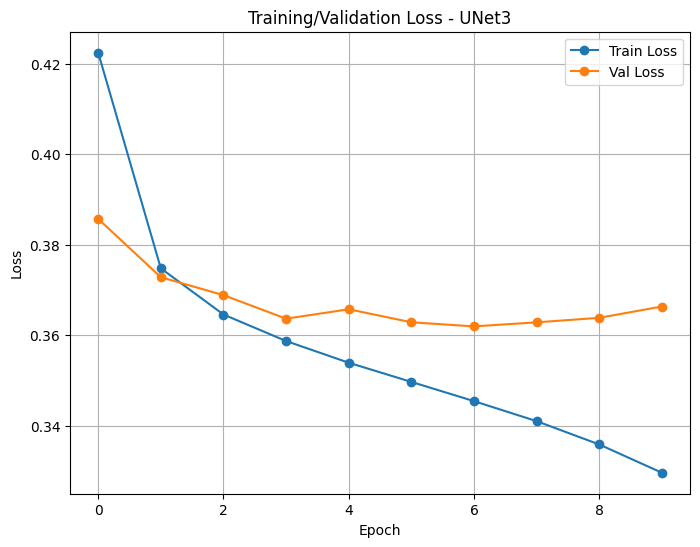

In [6]:
train_losses_unet3, val_losses_unet3, best_path_unet3 = train_model(
    model_unet3,
    train_loader,
    val_loader,
    optimizer_unet3,
    criterion_unet3,
    device,
    num_epochs=GLOBAL_NUM_EPOCHS,
    checkpoint_filename=None
)

plots.plot_training_curves(train_losses_unet3, val_losses_unet3, model_unet3, save_path="results/UNet3 Loss.png")

### 5.4. UNet3 Model Evaluation

In [6]:
model_unet3 = load_checkpoint(model_unet3, "results/checkpoints/UNet3.pth", device)

Loaded model from results/checkpoints/UNet3.pth (epoch 7)


In [7]:
df = pd.read_csv(CSV_PATH)
gt_csv = {row["mask_filename"]: row["angle"] for _, row in df.iterrows()}
data_unet3, avg_loss_unet3 = collect_evaluation_data(model_unet3, test_loader, criterion_unet3, device, gt_csv)


Segmentation Test Loss: 0.3620
Per-class IoUs:
  Class 0: IoU = 0.8959
  Class 1: IoU = 0.4852
  Class 2: IoU = 0.4827
Foreground mIoU (head & tail): 0.4839

Orientation Error:
  Mean Error:   14.79°
  Std Dev:      31.57°
  Median Error: 6.49°
  50% of samples ≤ 6.49° error
  75% of samples ≤ 12.16° error
  90% of samples ≤ 21.91° error
  95% of samples ≤ 50.57° error
  99% of samples ≤ 174.60° error


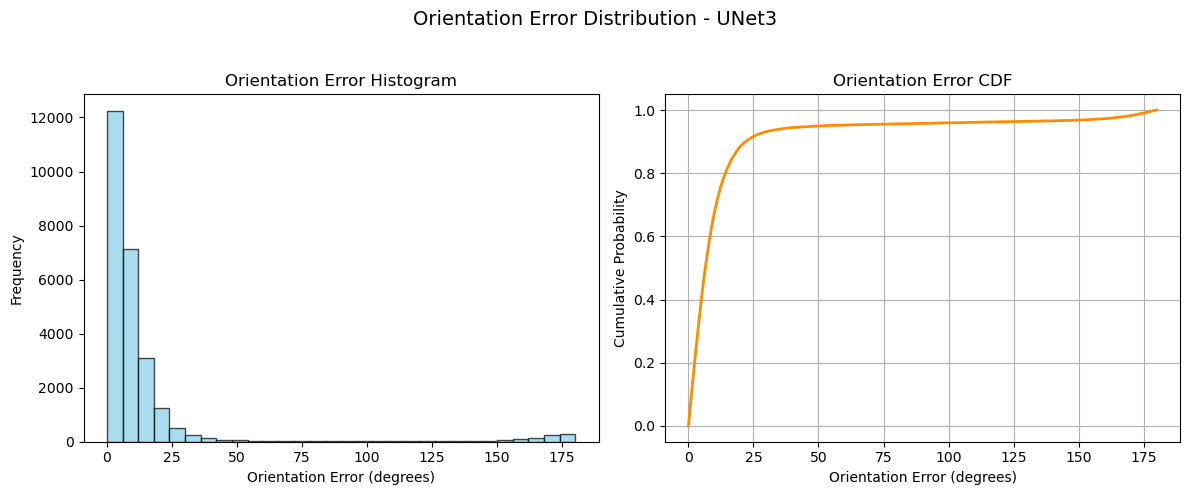

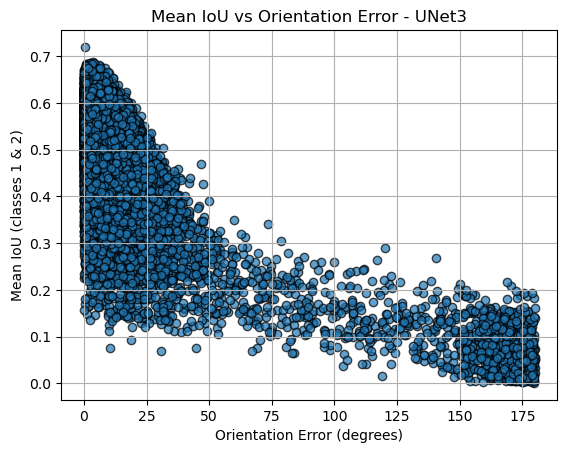

Spearman: rho=-0.40, p=0.0000
Pearson: r=-0.73, p=0.0000
Saved hexbin plot to results/UNet3 mIoU vs Orientation Error.png


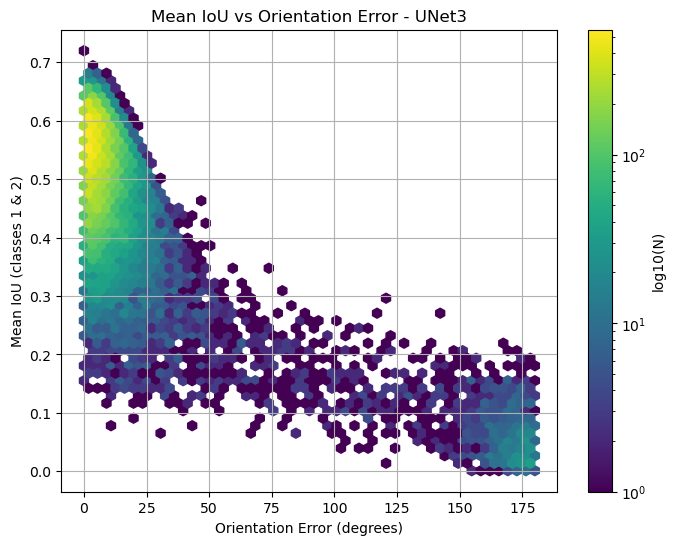

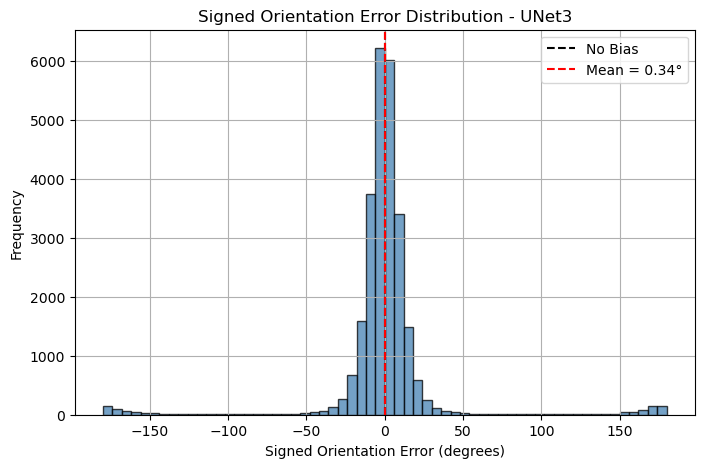

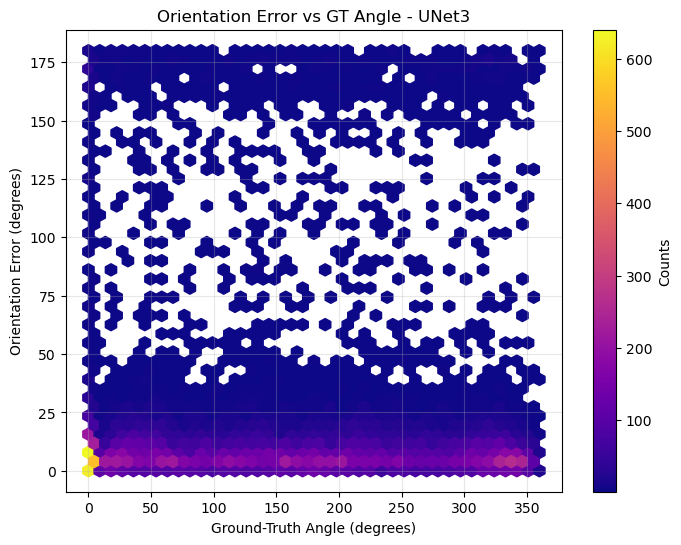

In [8]:
results_unet3 = evaluate_on_test(data_unet3, avg_loss_unet3)
plots.plot_orientation_error_distribution(results_unet3["orientation"]["all_errors_deg"], model_unet3, save_path="results/UNet3 Orientation Error.png")
plots.plot_miou_vs_orientation_error(data_unet3, model_unet3)
plots.plot_miou_vs_orientation_error_hexbin(data_unet3, model_unet3, save_path="results/UNet3 mIoU vs Orientation Error.png")
plots.plot_signed_orientation_error_distribution(data_unet3, model_unet3, save_path="results/UNet3 Signed Orientation Error Distribution.png")
plots.plot_orientation_error_vs_gt_angle_hexbin(data_unet3, model_unet3, save_path="results/UNet3 Orientation Error vs GT-Angle.png")

### 5.5. UNet3 Model Size

In [8]:
total_params_unet3 = sum(p.numel() for p in model_unet3.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters in UNet3: {total_params_unet3}")


Number of trainable parameters in UNet3: 1927907


### 5.6. UNet3 Example Prediction Masks

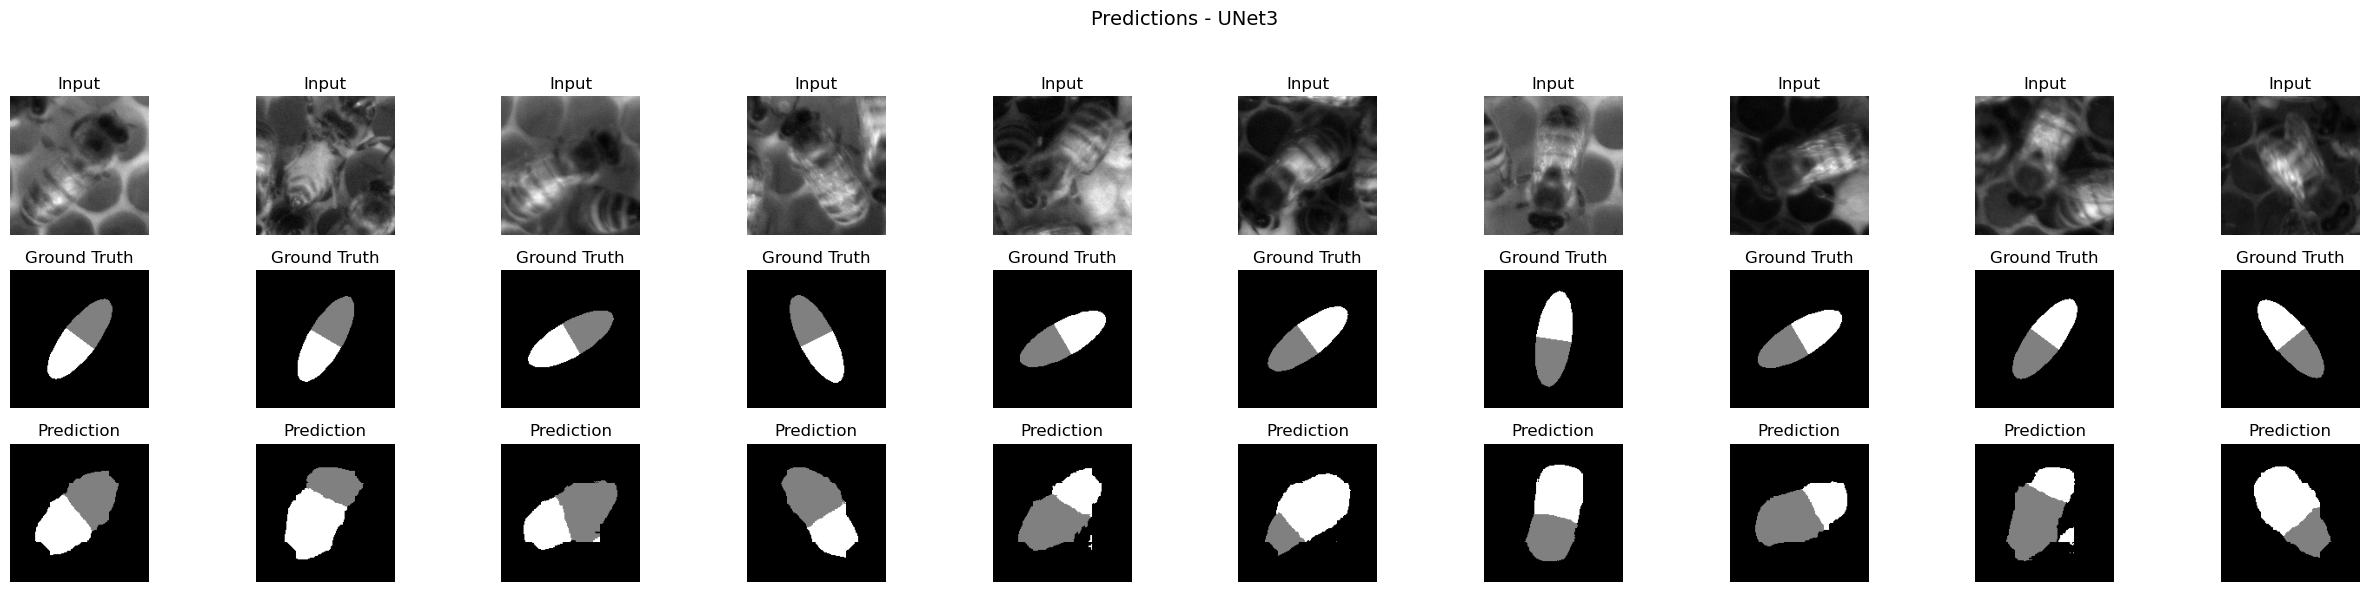

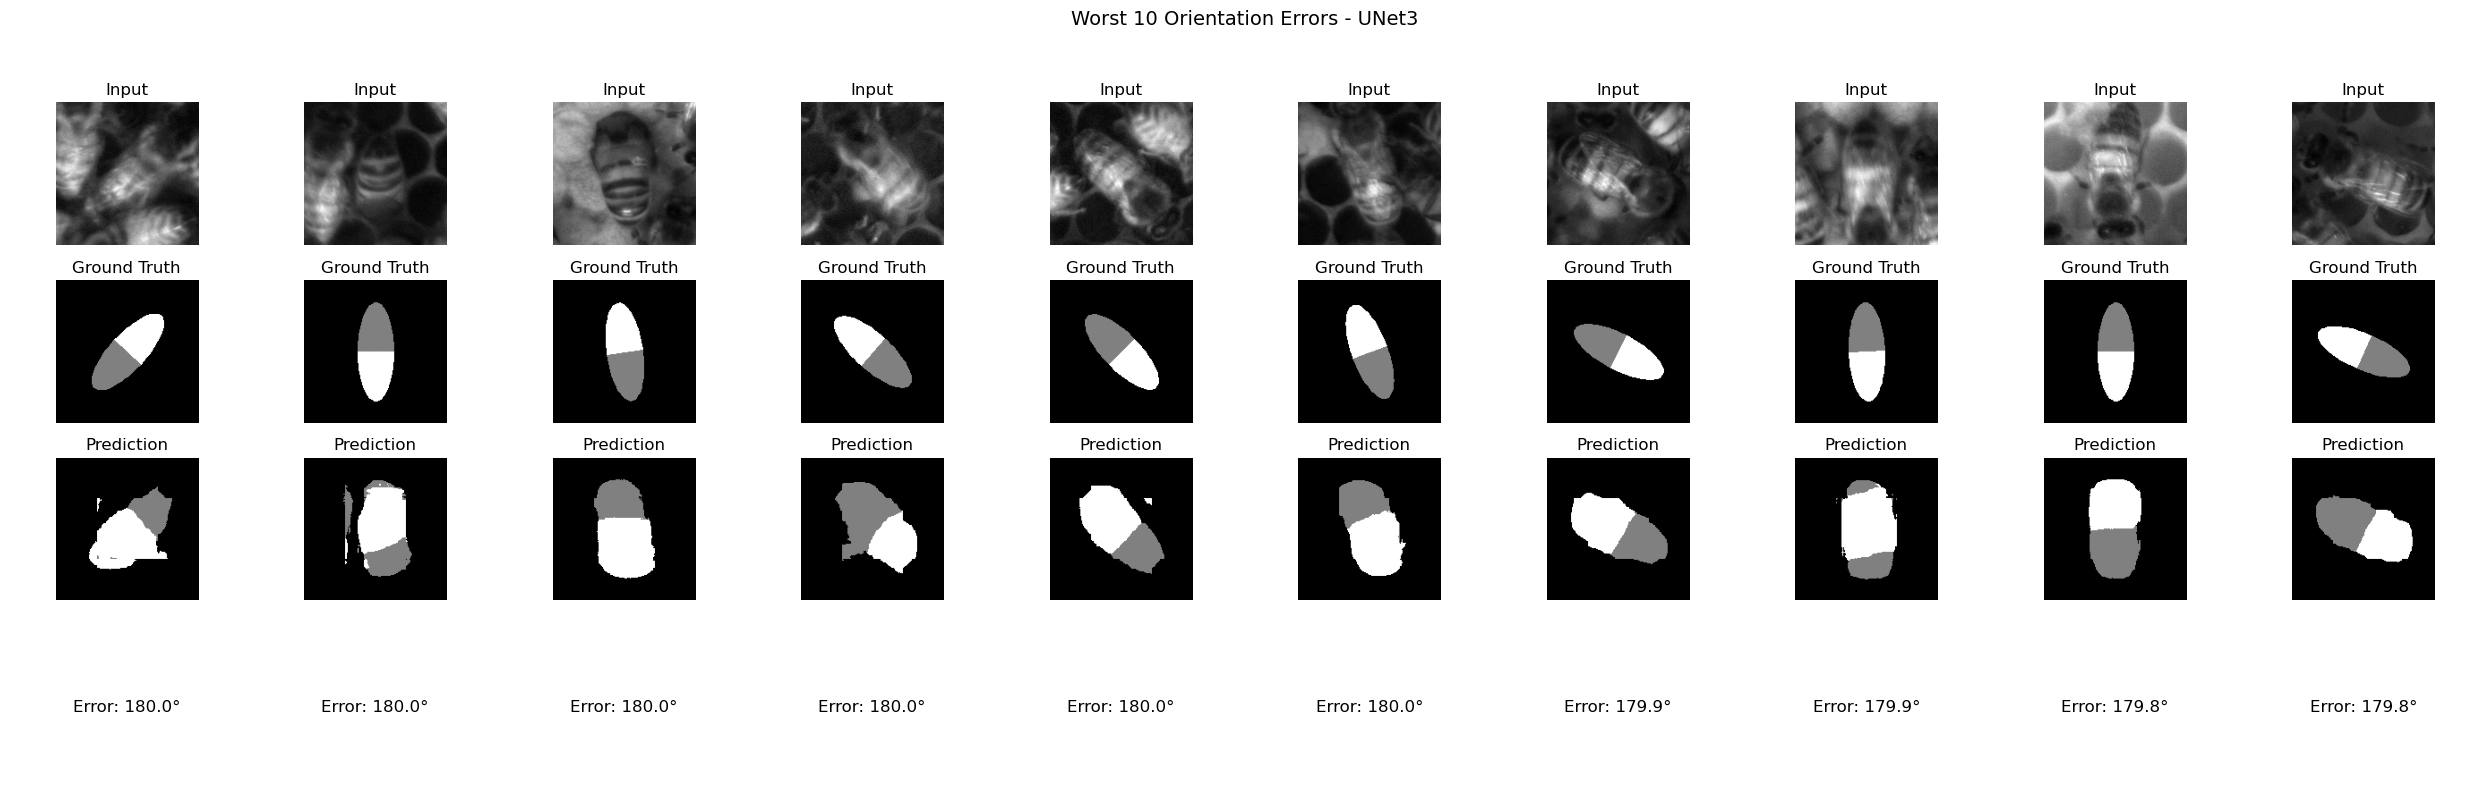

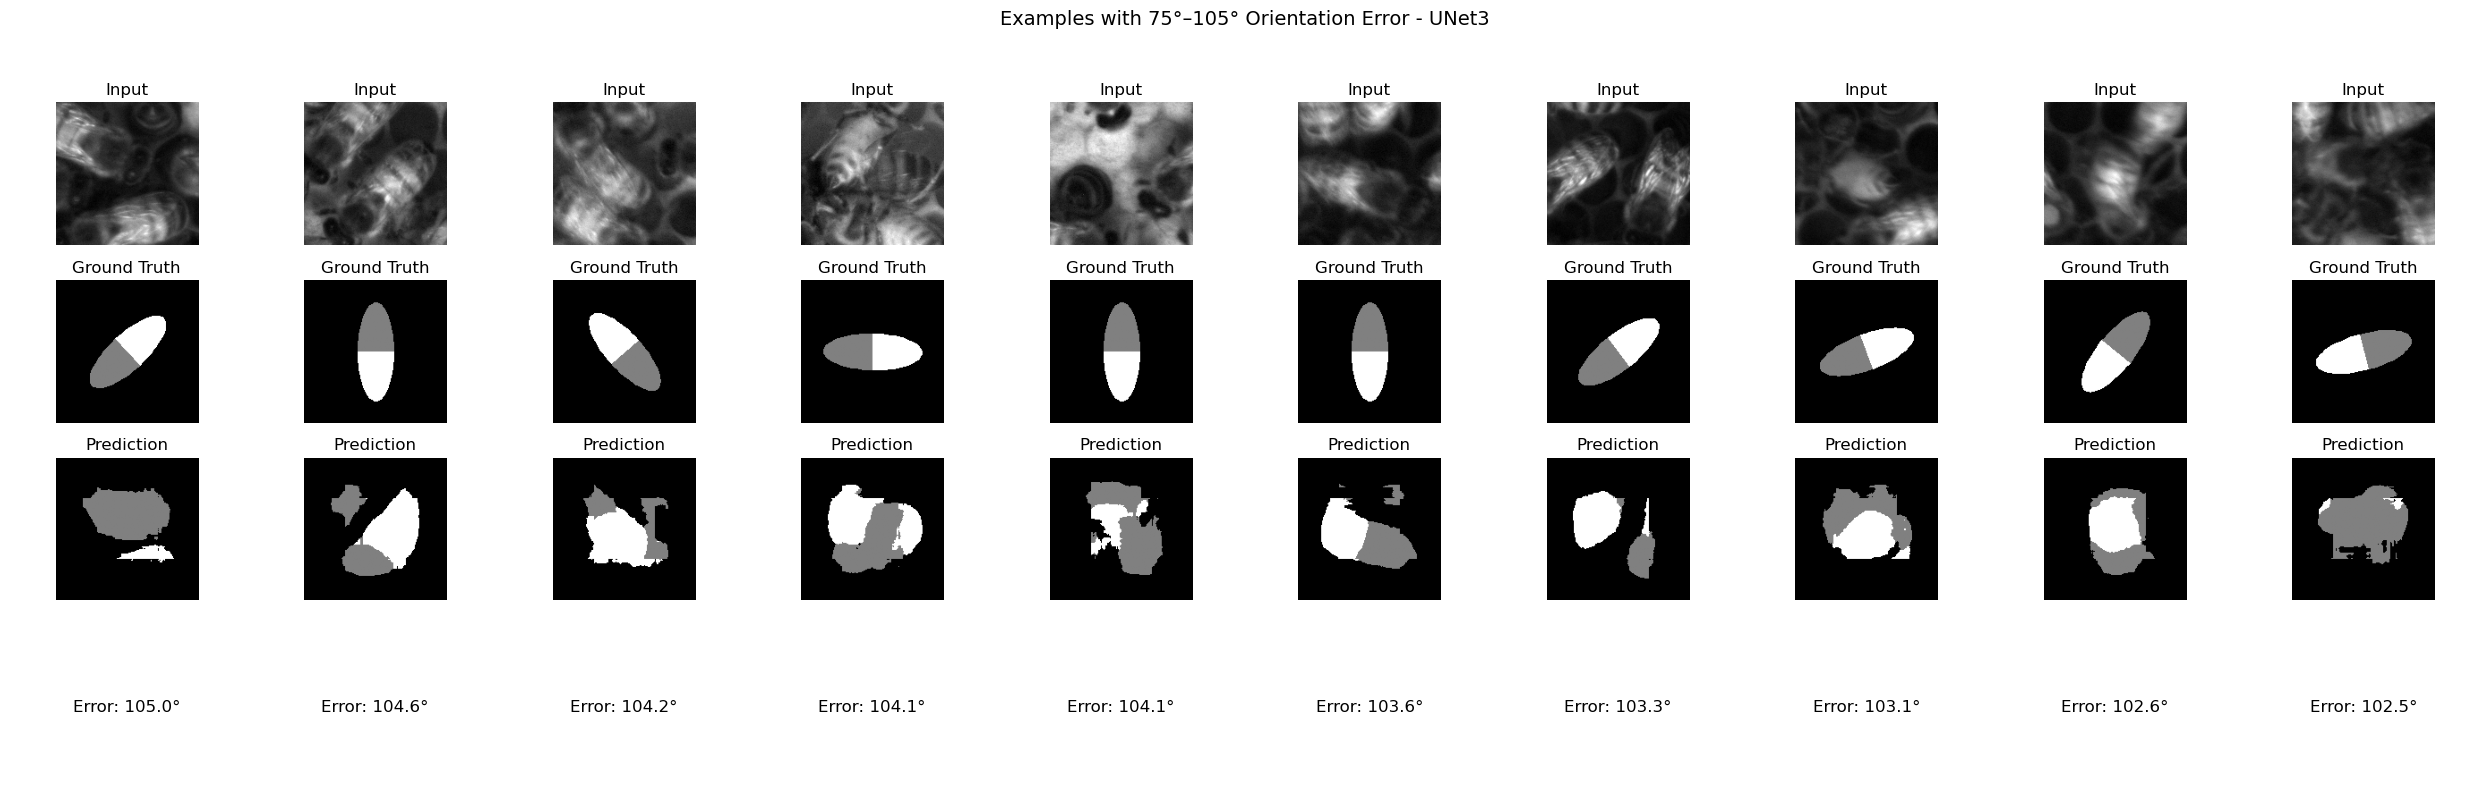

In [9]:
plots.plot_predictions(data_unet3, model_unet3, save_path="results/UNet3 Prediction Masks.png")
plots.plot_worst_orientation_errors(data_unet3, model_unet3, save_path="results/UNet3 Worst Orientation Errors.png")
plots.plot_orientation_errors_in_range(data_unet3, model_unet3, save_path="results/UNet3 Orientation Errors 90deg Range.png")

## 6. Experiment for ResUNet18 Model

This section runs the complete experiment pipeline specifically for the `ResUNet18` model.

### 6.1. ResUNet18 Model Definition

In [4]:
print(f"\n{'='*80}")
print("Starting Experiment for Model: ResUNet18")
print(f"{'='*80}\n")

model_resunet18 = ResUNet18().to(device)


Starting Experiment for Model: ResUNet18



### 6.2. ResUNet18 Training Setup

In [5]:
criterion_resunet18 = nn.CrossEntropyLoss(weight=GLOBAL_LOSS_WEIGHTS)
optimizer_resunet18 = torch.optim.Adam(model_resunet18.parameters(), lr=GLOBAL_LEARNING_RATE)

### 6.3. ResUNet18 Model Training

Epoch 1/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.93it/s]


  Train Loss: 0.2197 | Val Loss: 0.1913
  New best model saved at epoch 1

Epoch 2/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.91it/s]


  Train Loss: 0.1780 | Val Loss: 0.1795
  New best model saved at epoch 2

Epoch 3/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.96it/s]


  Train Loss: 0.1688 | Val Loss: 0.1751
  New best model saved at epoch 3

Epoch 4/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.97it/s]


  Train Loss: 0.1609 | Val Loss: 0.1803

Epoch 5/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.94it/s]


  Train Loss: 0.1501 | Val Loss: 0.1816

Epoch 6/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.98it/s]


  Train Loss: 0.1346 | Val Loss: 0.1937

Epoch 7/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.94it/s]


  Train Loss: 0.1149 | Val Loss: 0.2109

Epoch 8/10


Validation: 100%|██████████| 326/326 [00:37<00:00,  8.81it/s]


  Train Loss: 0.0987 | Val Loss: 0.2176

Epoch 9/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  8.95it/s]


  Train Loss: 0.0896 | Val Loss: 0.2579

Epoch 10/10


Validation: 100%|██████████| 326/326 [00:36<00:00,  9.00it/s]


  Train Loss: 0.0826 | Val Loss: 0.2698


Training finished. Best val loss: 0.1751 at epoch 3
Best model saved at: results/checkpoints/ResUNet18.pth


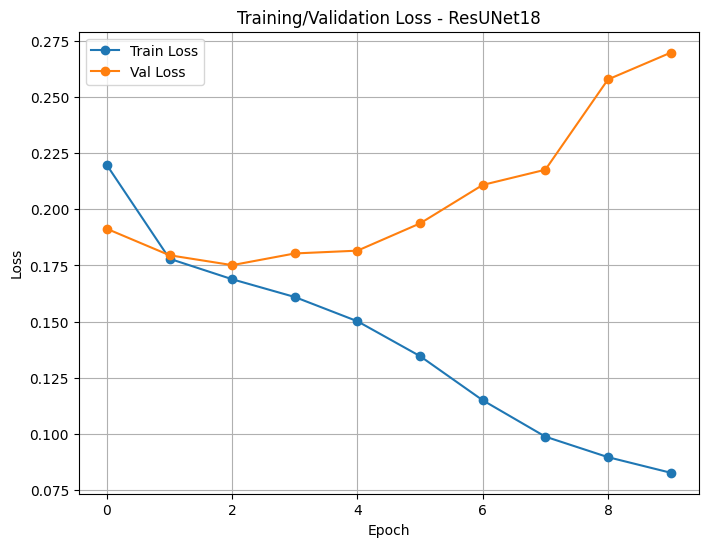

In [12]:
train_losses_resunet18, val_losses_resunet18, best_path_resunet18 = train_model(
    model_resunet18,
    train_loader,
    val_loader,
    optimizer_resunet18,
    criterion_resunet18,
    device,
    num_epochs=GLOBAL_NUM_EPOCHS,
    checkpoint_filename=None
)

plots.plot_training_curves(train_losses_resunet18, val_losses_resunet18, model_resunet18, save_path="results/ResUNet18 Loss.png")

### 6.4. ResUNet18 Model Evaluation

In [6]:
model_resunet18 = load_checkpoint(model_resunet18, "results/checkpoints/ResUNet18.pth", device)

Loaded model from results/checkpoints/ResUNet18.pth (epoch 3)


In [7]:
df = pd.read_csv(CSV_PATH)
gt_csv = {row["mask_filename"]: row["angle"] for _, row in df.iterrows()}
data_resunet18, avg_loss_resunet18 = collect_evaluation_data(model_resunet18, test_loader, criterion_resunet18, device, gt_csv)


Segmentation Test Loss: 0.1742
Per-class IoUs:
  Class 0: IoU = 0.9482
  Class 1: IoU = 0.7069
  Class 2: IoU = 0.7205
Foreground mIoU (head & tail): 0.7137

Orientation Error:
  Mean Error:   13.23°
  Std Dev:      31.12°
  Median Error: 5.73°
  50% of samples ≤ 5.73° error
  75% of samples ≤ 10.59° error
  90% of samples ≤ 17.98° error
  95% of samples ≤ 30.25° error
  99% of samples ≤ 175.74° error


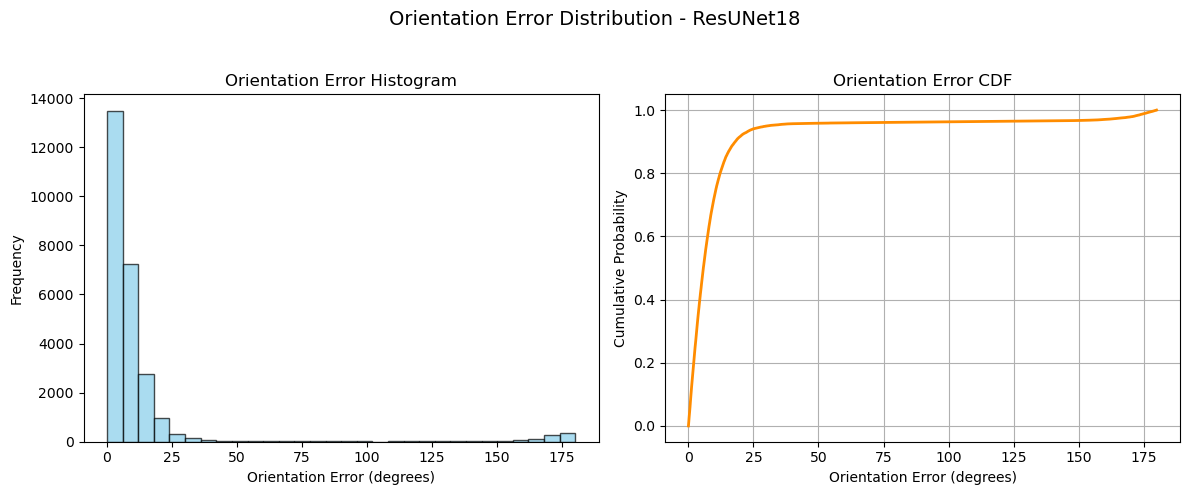

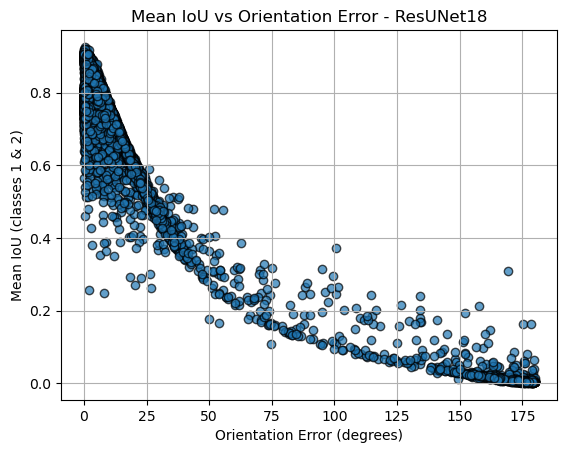

Spearman: rho=-0.73, p=0.0000
Pearson: r=-0.94, p=0.0000
Saved hexbin plot to results/ResUNet18 mIoU vs Orientation Error.png


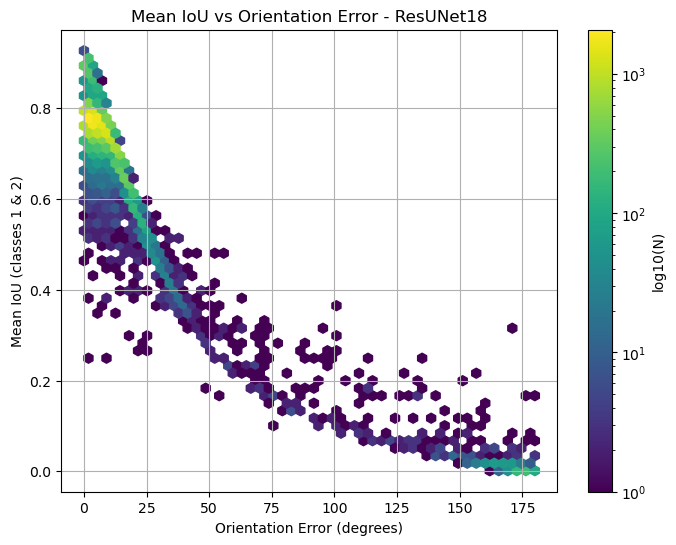

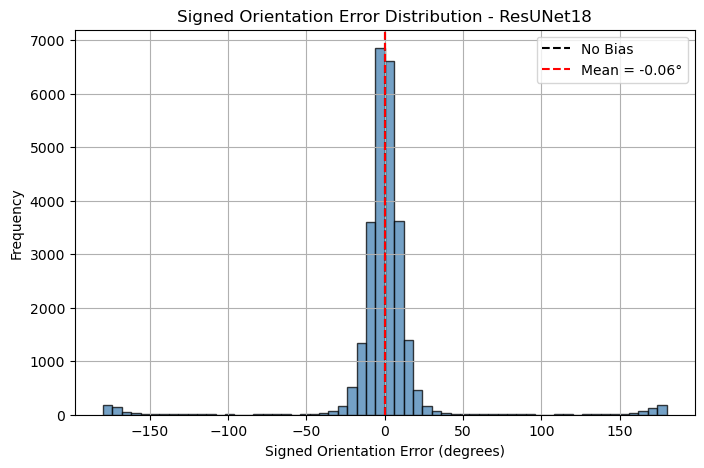

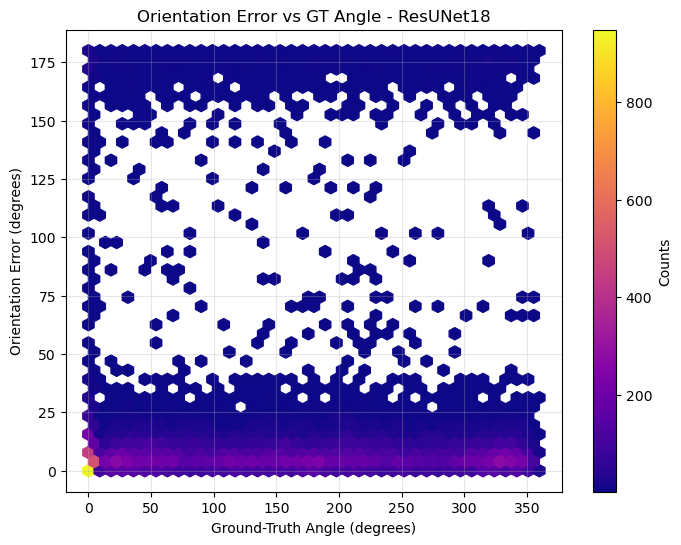

In [8]:
results_resunet18 = evaluate_on_test(data_resunet18, avg_loss_resunet18)
plots.plot_orientation_error_distribution(results_resunet18["orientation"]["all_errors_deg"], model_resunet18, save_path="results/ResUNet18 Orientation Error.png")
plots.plot_miou_vs_orientation_error(data_resunet18, model_resunet18)
plots.plot_miou_vs_orientation_error_hexbin(data_resunet18, model_resunet18, save_path="results/ResUNet18 mIoU vs Orientation Error.png")
plots.plot_signed_orientation_error_distribution(data_resunet18, model_resunet18, save_path="results/ResUNet18 Signed Orientation Error Distribution.png")
plots.plot_orientation_error_vs_gt_angle_hexbin(data_resunet18, model_resunet18, save_path="results/ResUNet18 Orientation Error vs GT-Angle.png")

### 6.5. ResUNet18 Model Size

In [14]:
total_params_resunet18 = sum(p.numel() for p in model_resunet18.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters in ResUNet18: {total_params_resunet18}")


Number of trainable parameters in ResUNet18: 14239721


### 6.6. ResUNet18 Example Prediction Masks

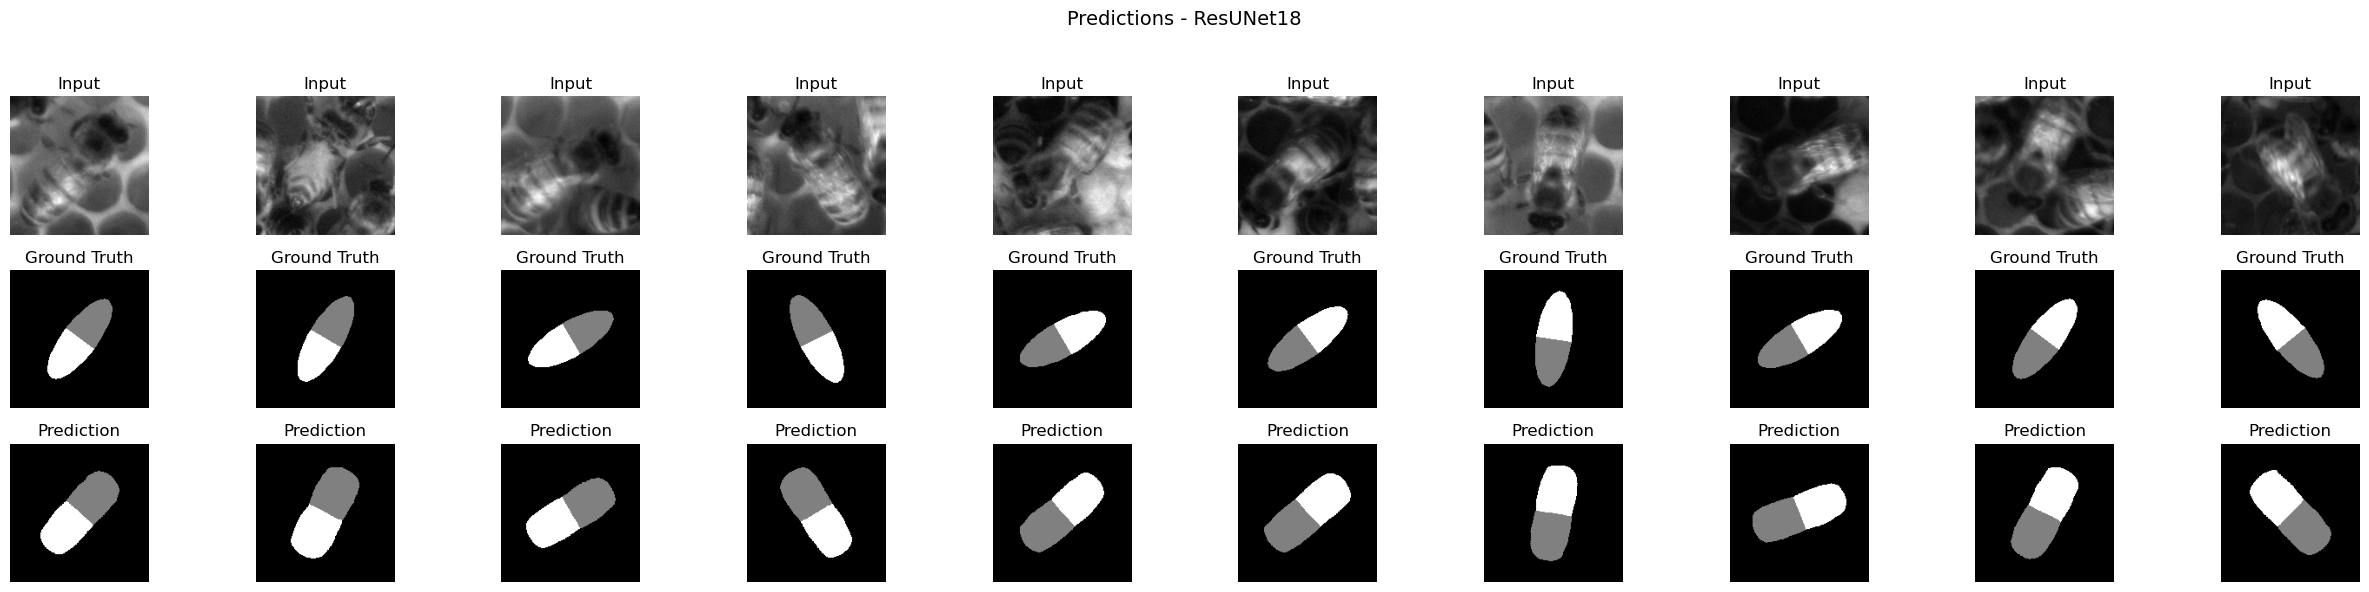

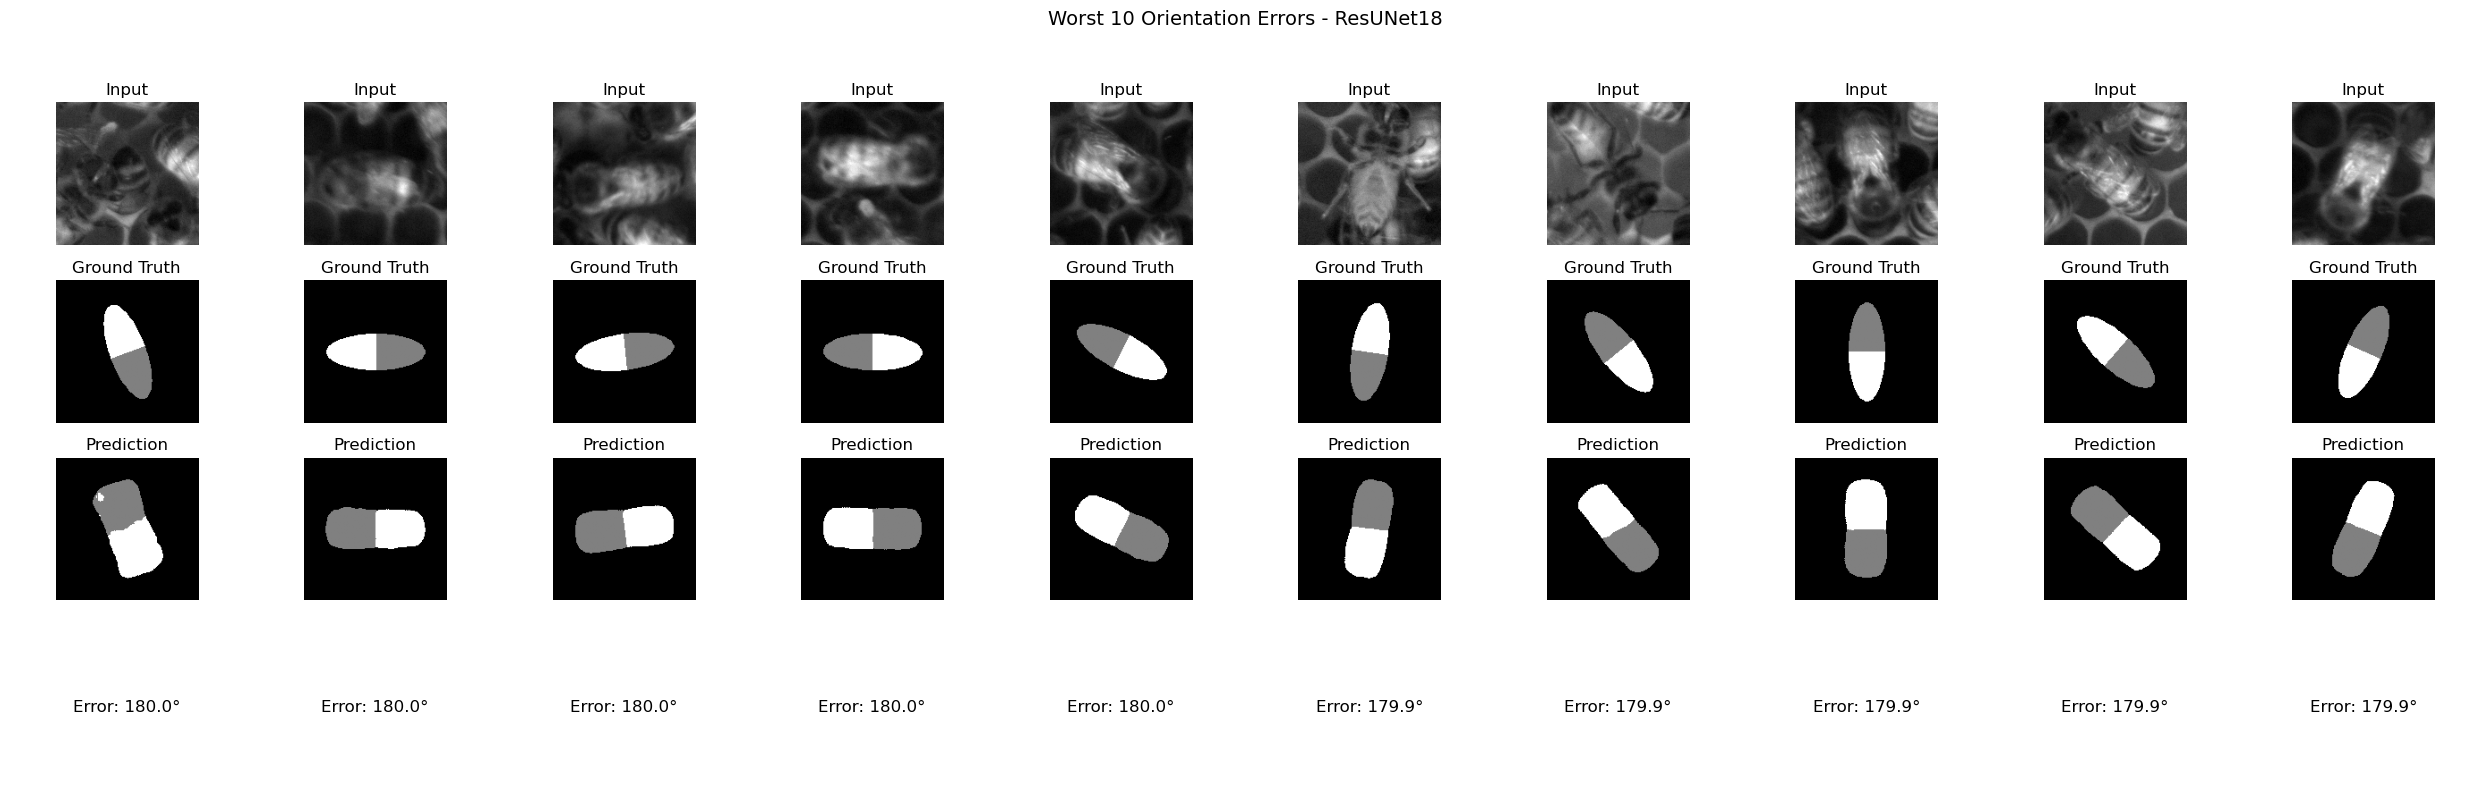

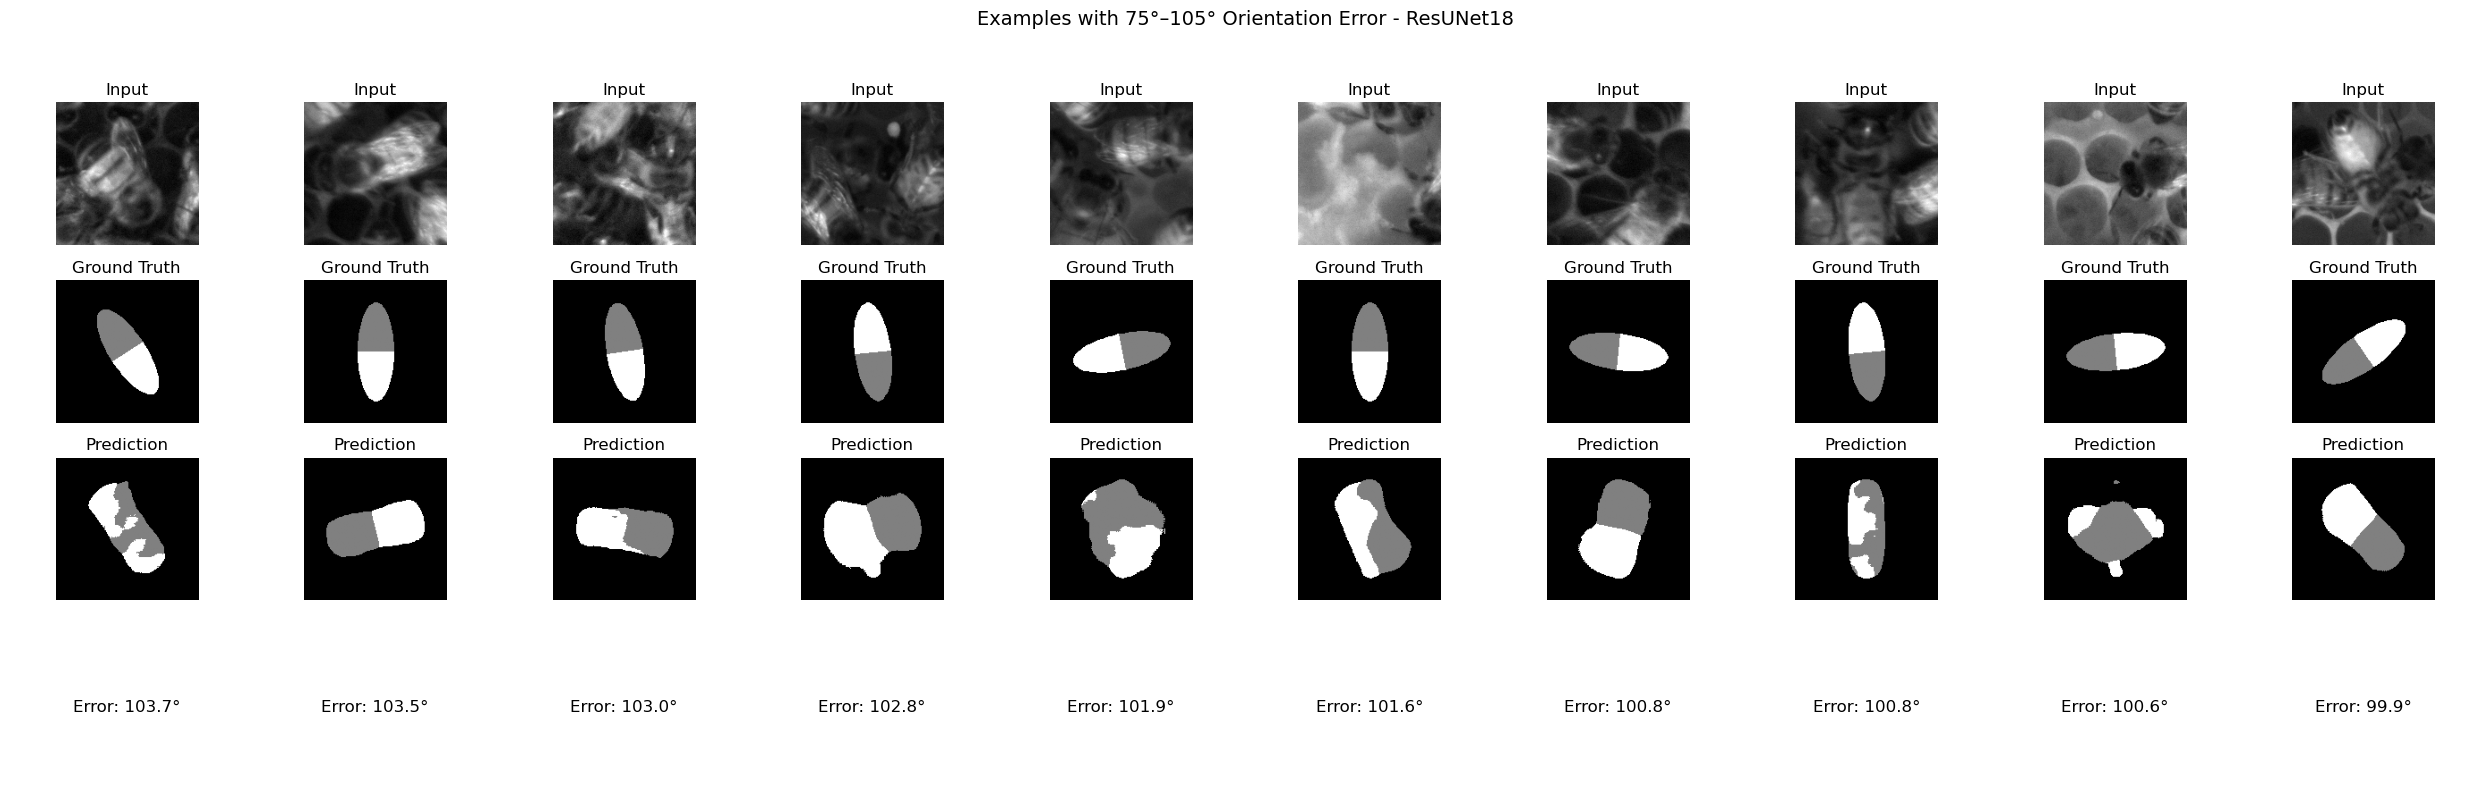

In [9]:
plots.plot_predictions(data_resunet18, model_resunet18, save_path="results/ResUNet18 Prediction Masks.png")
plots.plot_worst_orientation_errors(data_resunet18, model_resunet18, save_path="results/ResUNet18 Worst Orientation Errors.png")
plots.plot_orientation_errors_in_range(data_resunet18, model_resunet18, save_path="results/ResUNet18 Orientation Errors 90deg Range.png")